In [1]:
import numpy as np
import obspy
from hydrophone_data_processing import load, useful_variables, plotting, signal_processing
import scipy.signal as signal
import pandas as pd
import matplotlib.dates as dates
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import config

def import_data(day, starttime, endtime):
    daypaths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=day)
    starttime = obspy.UTCDateTime(starttime)
    endtime = obspy.UTCDateTime(endtime)
    data = load.import_corrected_data_for_single_day(daypaths)
    data.trim(starttime=starttime, endtime=endtime)
    return data

In [2]:
day141 = import_data(day=141, starttime='2019-05-21T07:00:00.0Z', endtime='2019-05-21T09:00:00.0Z')

In [3]:
day188 = import_data(day=188, starttime='2019-07-07T08:40:00.0Z', endtime='2019-07-07T10:15:00.0Z')

In [4]:
day197 = import_data(day=197, starttime='2019-07-16T21:45:00.0Z', endtime='2019-07-17T00:00:00.337999Z')

In [5]:
day211 = import_data(day=211, starttime='2019-07-30T22:30:05.142999Z', endtime='2019-07-30T23:07:04.430999Z')

In [6]:
import matplotlib.dates as dates

def import_catalog(file):
    df = pd.read_csv(file)
    df.sort_values(by='first_arrival', inplace=True)
    df['arrival_datetime'] = df.arrival_time.apply(dates.num2date)
    return df

In [7]:
df141 = import_catalog(file='141precision.csv')
df188 = import_catalog(file='188precision.csv')
df197 = import_catalog(file='197precision.csv')
df211 = import_catalog(file='211precision.csv')

In [22]:
df141.first_hydrophone.unique()

array([5, 4, 3, 2])

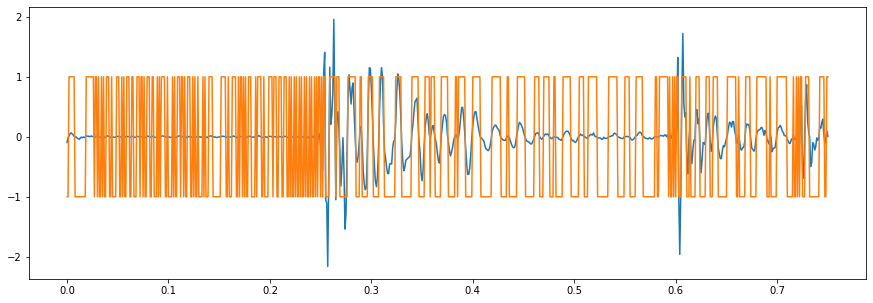

In [190]:
event = df141.iloc[1520]

# starttime = obspy.UTCDateTime(event.parrival.replace(' ', 'T'))
starttime = obspy.UTCDateTime(event.first_arrival.replace(' ', 'T'))

# data = day141.slice(starttime=starttime-0.02, endtime=starttime+0.05).filter(type='highpass', freq=50)
data = day141.slice(starttime=starttime-0.25, endtime=starttime+0.5).filter(type='highpass', freq=50)

fig, ax = plt.subplots(figsize=(15, 5))

wf = data[event.first_hydrophone].data
ts = data[event.first_hydrophone].times()

ax.plot(ts, wf)
# ax.set_ylim(-0.5, 0.05)
plt.plot(ts, np.sign(wf))

Text(0.051, 500, 'first arrival')

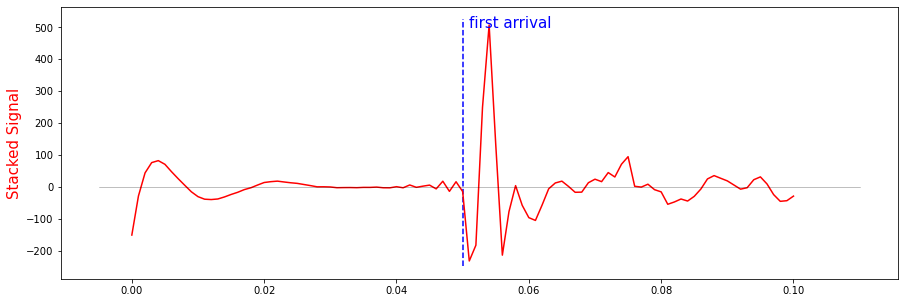

In [210]:
# event = df141.iloc[1250]

fig, ax = plt.subplots(figsize=(15, 5))

wfs = np.zeros_like(wf)
tss = np.array([])

for i, event in df141.iterrows():

    starttime = obspy.UTCDateTime(event.first_arrival.replace(' ', 'T'))

    data = day141.slice(starttime=starttime-0.05, endtime=starttime+0.05).filter(type='highpass', freq=50)


    wf = data[event.first_hydrophone].data
    ts = data[event.first_hydrophone].times()
    
    wfs = wfs + wf

ax.plot(ts, wfs, color='red')
ax.set_ylabel('Stacked Signal', fontsize=15, color='red')

ax.plot([-0.005, 0.11], [0, 0], color='black', linewidth=0.5, alpha=0.5)


ax.vlines(0.05, -250, 525, color='blue', linestyle='--')
ax.text(s='first arrival', x=0.051, y=500, fontsize=15, color='blue')

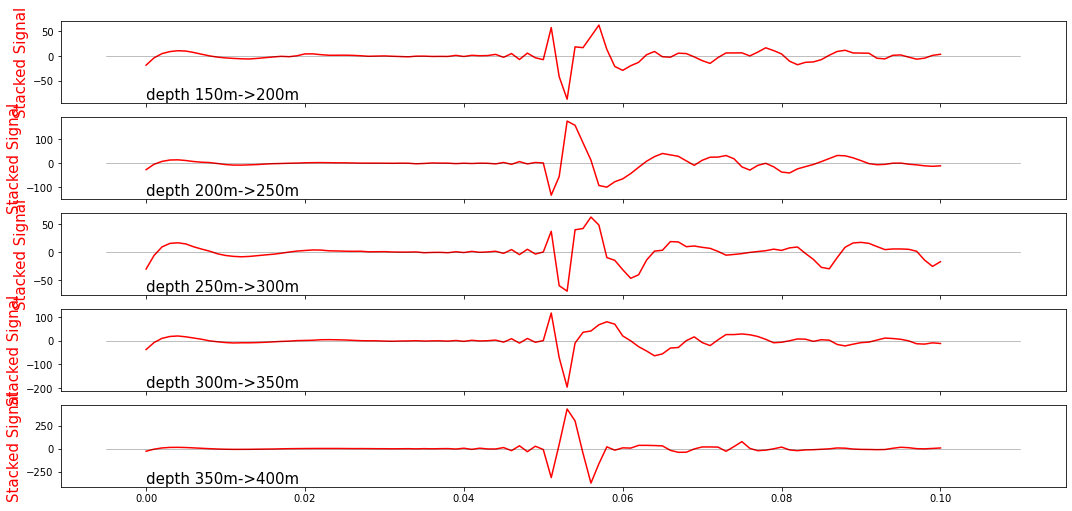

In [219]:



def get_stacked_signal(df):
    wfs = np.zeros(101)
    tss = np.array([])
    
    for i, event in df.iterrows():

        starttime = obspy.UTCDateTime(event.first_arrival.replace(' ', 'T'))

        data = day141.slice(starttime=starttime-0.05, endtime=starttime+0.05).filter(type='highpass', freq=50)


        wf = data[event.first_hydrophone].data
        ts = data[event.first_hydrophone].times()

        wfs = wfs + wf
        
    return ts, wfs

fig, ax = plt.subplots(5, 1, figsize=(15, 7), sharex=True)

depths = np.arange(150, 450, 50)

for i, depth in enumerate(depths):
    if i==5:
        break
    ts, wfs = get_stacked_signal(df=df141[df141.depth.between(depth, depth+50)].copy())

    ax[i].plot(ts, wfs, color='red')
    ax[i].set_ylabel('Stacked Signal', fontsize=15, color='red')
    ax[i].plot([-0.005, 0.11], [0, 0], color='black', linewidth=0.5, alpha=0.5)
    ax[i].text(s=f'depth {depth}m->{depth+50}m', x=0.0, y=wfs.min(), fontsize=15)



# ax.vlines(0.05, -250, 525, color='blue', linestyle='--')
# ax.text(s='first arrival', x=0.051, y=500, fontsize=15, color='blue')
fig.tight_layout()

In [212]:
depths

array([150, 200, 250, 300, 350, 400])

In [206]:
wf.shape

(101,)

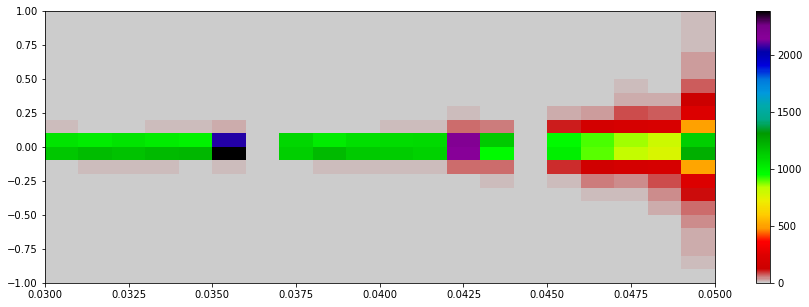

In [149]:
# event = df141.iloc[1250]

fig, ax = plt.subplots(figsize=(15, 5))

wfs = np.array([])
tss = np.array([])

for i, event in df141.iterrows():

    starttime = obspy.UTCDateTime(event.first_arrival.replace(' ', 'T'))

    data = day141.slice(starttime=starttime-0.05, endtime=starttime+0.05).filter(type='highpass', freq=50)


    wf = data[event.first_hydrophone].data
    ts = data[event.first_hydrophone].times()
    
    wfs = np.concatenate([wfs, wf])
    tss = np.concatenate([tss, ts])

    # ax.plot(ts, wf, alpha=0.01, color='black', linewidth=0.5)
    # if i > 1000:
        # break
    
_,_,_,cbar = ax.hist2d(x=tss, y=wfs, bins=20
                       , range=[[0.03, 0.05], [-1, 1]]
                       # , vmin=0, vmax=200
                       , cmap='nipy_spectral_r')
fig.colorbar(cbar)
# ax.set_ylim(-5, 5)
# ax.set_xlim(0.02, 0.03)

Text(0, 0.5, 'Stacked Sign')

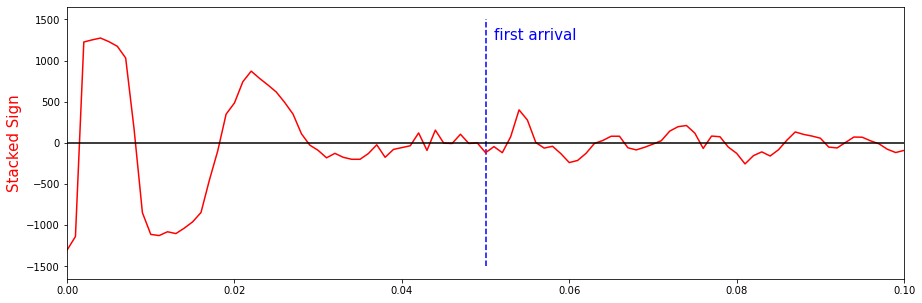

In [178]:
# event = df141.iloc[1250]

fig, ax = plt.subplots(figsize=(15, 5))

# wfs = np.array([])
wfs = np.zeros_like(wf)
wfs_positive = np.zeros_like(wf)
wfs_negative = np.zeros_like(wf)
tss = np.array([])

for i, event in df141.iterrows():

    # starttime = obspy.UTCDateTime(event.parrival.replace(' ', 'T'))
    starttime = obspy.UTCDateTime(event.first_arrival.replace(' ', 'T'))

    data = day141.slice(starttime=starttime-0.05, endtime=starttime+0.05).filter(type='highpass', freq=50)


    wf = data[event.first_hydrophone].data
    ts = data[event.first_hydrophone].times()
    
    wfs = wfs + np.sign(wf)
    
    wf_positive = np.sign(wf.copy())
    wf_positive[wf_positive==-1] = 0
    wfs_positive = wfs_positive + wf_positive
    
    wf_negative = np.sign(wf.copy())
    wf_negative[wf_negative==1] = 0
    wf_negative = wf_negative*(-1)
    wfs_negative = wfs_negative + wf_negative
    
    

ax.plot(ts, wfs, color='red')
ax.plot([0, 0.15], [0, 0], color='black')
ax.set_xlim(0, 0.1)
# ax.set_ylim(-1500, 1500)

ax.vlines(0.05, -1500, 1500, color='blue', linestyle='--')
ax.text(s='first arrival', x=0.051, y=1250, fontsize=15, color='blue')
ax.set_ylabel('Stacked Sign', fontsize=15, color='red')

# ax2 = ax.twinx()
# ax2.set_ylabel('Count', fontsize=15)
# ax2.plot(ts, wfs_positive, label='positive')
# ax2.plot(ts, wfs_negative, label='negative')
# ax2.legend(fontsize=15)

# ax.set_ylim(-500, 500)

(0.1, 0.9)

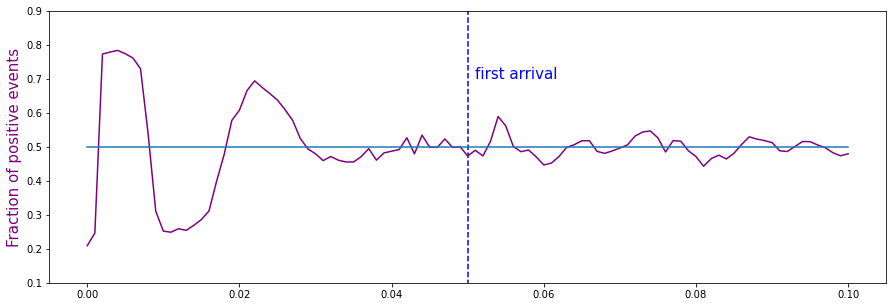

In [188]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(ts, wfs_positive/(wfs_positive+wfs_negative), color='purple')
ax.plot(ts, np.zeros_like(ts)+0.5)

ax.set_ylabel('Fraction of positive events', fontsize=15, color='purple')

ax.vlines(0.05, 0, 1, color='blue', linestyle='--')
ax.text(s='first arrival', x=0.051, y=0.7, fontsize=15, color='blue')

ax.set_ylim(0.1, 0.9)


In [167]:
wfs_positive

array([-1.51556195e+02, -2.91016596e+01,  4.34728080e+01,  7.56939339e+01,
        8.18528824e+01,  7.03741480e+01,  4.71343269e+01,  2.53184723e+01,
        4.54717577e+00, -1.58977092e+01, -3.10792534e+01, -3.90659659e+01,
       -4.01867389e+01, -3.83747768e+01, -3.20280937e+01, -2.42550658e+01,
       -1.74343070e+01, -9.00709594e+00, -3.14386244e+00,  5.30568564e+00,
        1.32602722e+01,  1.58842972e+01,  1.75580171e+01,  1.49375774e+01,
        1.24911984e+01,  1.05455214e+01,  7.03505449e+00,  3.55905975e+00,
       -2.59925146e-01, -1.62079151e-01, -7.14127335e-01, -3.06194250e+00,
       -2.67392559e+00, -2.53919168e+00, -2.98820754e+00, -2.02795890e+00,
       -2.08648244e+00, -1.09914029e+00, -3.23965475e+00, -3.39895369e+00,
        1.95820998e-01, -3.26161522e+00,  5.53426019e+00, -1.83314824e+00,
        1.83589242e+00,  5.10172788e+00, -6.69259183e+00,  1.72844080e+01,
       -1.44583490e+01,  1.56735723e+01, -1.50217939e+01, -2.32789515e+02,
       -1.83397417e+02,  

In [203]:
np.arange(150, 450, 50)

array([150, 200, 250, 300, 350, 400])